In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Detalles:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Detalles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
# Ruta al dataset filtrado
DATASET_DIR = r'C:\Users\oicas\OneDrive\Desktop\Intro a las App de Algoritmos de ML y DL\Proyecto\Dataset\dataset_proyecto_final'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64 #32, 64 o 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print('Cargando generadores de entrenamiento y validación...')
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

validation_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

Cargando generadores de entrenamiento y validación...
Found 9901 images belonging to 6 classes.
Found 2474 images belonging to 6 classes.


In [19]:
# Calculamos los pesos por clase para balancear el entrenamiento
# Comprobar que `train_generator` existe y tiene el atributo `classes`
if 'train_generator' not in globals():
    raise NameError("'train_generator' no está definido. Ejecuta la celda que crea el generador de entrenamiento antes de esta celda.")
if not hasattr(train_generator, 'classes'):
    raise AttributeError("El objeto 'train_generator' no tiene el atributo 'classes'. Asegúrate de usar ImageDataGenerator.flow_from_directory o un DirectoryIterator.")

train_labels = train_generator.classes
# Calculamos los pesos para equilibrar
class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convertimos a diccionario para Keras {0: 1.5, 1: 0.5, ...}
class_weights = dict(enumerate(class_weights_list))

print("Pesos calculados para equilibrar el entrenamiento:")
for idx, weight in class_weights.items():
    style_name = list(train_generator.class_indices.keys())[idx]
    print(f"   {style_name}: {weight:.2f}")

Pesos calculados para equilibrar el entrenamiento:
   Abstract_Expressionism: 0.83
   Cubism: 0.92
   Impressionism: 0.83
   Pop_Art: 1.39
   Realism: 0.83
   Ukiyo_e: 1.77


In [ ]:
base_model = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Congelar la base para no dañar lo que ya sabe
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),       # Resume la información visual
    Dense(512, activation='relu'),  # Capa de pensamiento
    Dropout(0.5),                   # Apagar neuronas al azar para evitar     memorización
    Dense(6, activation='softmax')  # 6 neuronas de salida (una por estilo)
])

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Tasa de aprendizaje baja para ser precisos
    loss='categorical_crossentropy',      # Loss para >2 clases
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24,616,966
Trainable params: 1,052,166
Non-trainable params: 23,564,800
__________________________________

In [21]:
# Callbacks para guardar lo mejor y parar si no mejora
callbacks = [
    ModelCheckpoint('mejor_modelo_arte.keras', save_best_only=True, monitor='val_accuracy', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=15,                    #  15 epoch, para empezar
    validation_data=validation_generator,
    class_weight=class_weights,   # corrección
    callbacks=callbacks
)

print("Entrenamiento finalizado.")

Epoch 1/15
310/310 [==============================] - ETA: 0s - loss: 1.2734 - accuracy: 0.4950
Epoch 1: val_accuracy improved from -inf to 0.60146, saving model to mejor_modelo_arte.keras
310/310 [==============================] - 228s 729ms/step - loss: 1.2734 - accuracy: 0.4950 - val_loss: 0.9769 - val_accuracy: 0.6015
Epoch 2/15
310/310 [==============================] - ETA: 0s - loss: 0.9324 - accuracy: 0.6224
Epoch 2: val_accuracy improved from 0.60146 to 0.63743, saving model to mejor_modelo_arte.keras
310/310 [==============================] - 233s 751ms/step - loss: 0.9324 - accuracy: 0.6224 - val_loss: 0.8983 - val_accuracy: 0.6374
Epoch 3/15
310/310 [==============================] - ETA: 0s - loss: 0.8275 - accuracy: 0.6633
Epoch 3: val_accuracy improved from 0.63743 to 0.67017, saving model to mejor_modelo_arte.keras
310/310 [==============================] - 203s 655ms/step - loss: 0.8275 - accuracy: 0.6633 - val_loss: 0.8374 - val_accuracy: 0.6702
Epoch 4/15
310/310 [==

78/78 [==============================] - 23s 295ms/step


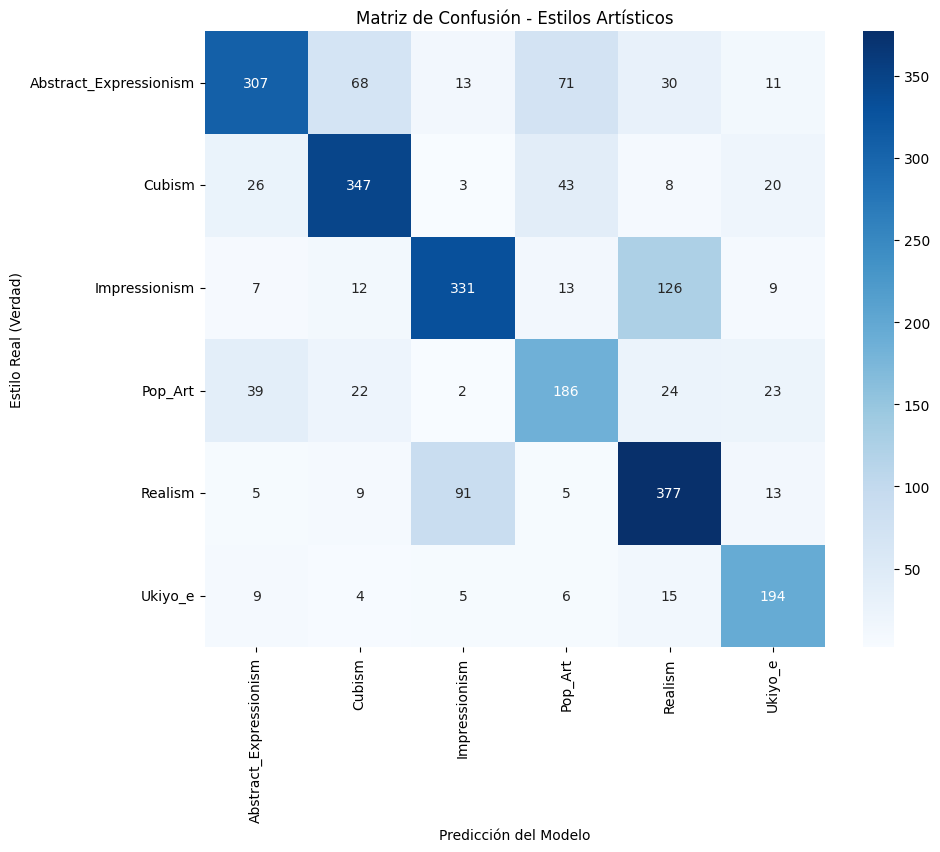


Reporte de Métricas por Estilo:
                        precision    recall  f1-score   support

Abstract_Expressionism       0.78      0.61      0.69       500
                Cubism       0.75      0.78      0.76       447
         Impressionism       0.74      0.66      0.70       498
               Pop_Art       0.57      0.63      0.60       296
               Realism       0.65      0.75      0.70       500
               Ukiyo_e       0.72      0.83      0.77       233

              accuracy                           0.70      2474
             macro avg       0.70      0.71      0.70      2474
          weighted avg       0.71      0.70      0.70      2474



In [26]:
# (Usamos el archivo .keras que guardó el ModelCheckpoint)
model = load_model('mejor_modelo_arte.keras')

# Es CRUCIAL resetearlo para que el orden de las predicciones coincida con el de las etiquetas reales
validation_generator.reset()

# predict devuelve probabilidades (ej: [0.1, 0.8, 0.05...])
y_pred_prob = model.predict(validation_generator, verbose=1)

# Convertimos probabilidades a la clase ganadora (ej: 1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtenemos las etiquetas reales (Ground Truth)
y_true = validation_generator.classes

# Nombres de las clases (para que el gráfico se entienda)
class_names = list(validation_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Estilos Artísticos')
plt.ylabel('Estilo Real (Verdad)')
plt.xlabel('Predicción del Modelo')
plt.show()

print("\nReporte de Métricas por Estilo:")
print(classification_report(y_true, y_pred, target_names=class_names))